In [1]:
# installing 'preprocess_kgptalkie' package to help in the preprocess
!pip install git+https://github.com/laxmimerit/preprocess_kgptalkie.git --upgrade --force-reinstall

  Cloning https://github.com/laxmimerit/preprocess_kgptalkie.git to /tmp/pip-req-build-gugxgzdb
  Running command git clone --filter=blob:none --quiet https://github.com/laxmimerit/preprocess_kgptalkie.git /tmp/pip-req-build-gugxgzdb
  Resolved https://github.com/laxmimerit/preprocess_kgptalkie.git to commit 96bf02872d9756f29d6cddb8aafaedcd2a39bbb4
  Preparing metadata (setup.py) ... done
  Created wheel for preprocess-kgptalkie: filename=preprocess_kgptalkie-0.1.3-py3-none-any.whl size=7602 sha256=e151950038c65e0657285e87557741c0c3a892eae582c07b61971685c3b21653
  Stored in directory: /tmp/pip-ephem-wheel-cache-bm92z309/wheels/5c/94/34/99d5ff65e88b8d9a6c5e8d8652f2311d87790a61a1b7466e21
Successfully built preprocess-kgptalkie


In [2]:
import spacy
import en_core_web_sm
import bs4
from textblob import TextBlob
import preprocess_kgptalkie as ps
import seaborn as sns
import pandas as pd
import re
import matplotlib.pyplot as plt
import gensim.downloader as api
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import nltk
from nltk.stem import PorterStemmer
import warnings
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score,recall_score,f1_score
from sklearn.metrics import classification_report, confusion_matrix
from nltk.stem.porter import PorterStemmer
import nltk
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder

warnings.filterwarnings('ignore')
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
# Loading the data
data_IMDB = pd.read_csv("/content/drive/MyDrive/AC/IMDB Dataset.csv")

In [4]:
def preprocess_text(text):
    # Remove non-alphabetic characters
    return re.sub(r'[^a-zA-Z]', ' ', text)

# Removing HTML tags
data_IMDB['review'] = data_IMDB['review'].apply(lambda x: ps.remove_html_tags(x))
# Removing accented chars
data_IMDB['review'] = data_IMDB['review'].apply(lambda x: ps.remove_accented_chars(x))
# Removing special chars
data_IMDB['review'] = data_IMDB['review'].apply(lambda x: ps.remove_special_chars(x))
# Converting all text to lowercase
data_IMDB["review"]= data_IMDB["review"].str.lower()
# Remove non-alphabetic characters
data_IMDB['review'] = data_IMDB['review'].apply(preprocess_text)

In [5]:
# Visualizing the distribution of sentiment labels
data_IMDB["sentiment"].value_counts().plot(kind='bar')
# Calculate the word count for each review
data_IMDB['word_count'] = data_IMDB['review'].apply(lambda x: ps.get_wordcounts(x))
# Calculate the char count for each review
data_IMDB['char_count'] = data_IMDB['review'].apply(lambda x: ps.get_charcounts(x))
# Calculate the average word length for each review
data_IMDB['avgerage_wordlength'] = data_IMDB['review'].apply(lambda x: ps.get_avg_wordlength(x))
# Calculate the stops words count for each review
data_IMDB['stopwords_count'] = data_IMDB['review'].apply(lambda x: ps.get_stopwords_counts(x))

In [6]:
# Removing stopwords from each review
data_IMDB['review_without_stopwords'] = data_IMDB['review'].apply(lambda x: ps.remove_stopwords(x))
data_IMDB

review sentiment  \
0      one of the other reviewers has mentioned that ...  positive   
1      a wonderful little production the filming tech...  positive   
2      i thought this was a wonderful way to spend ti...  positive   
3      basically theres a family where a little boy j...  negative   
4      petter matteis love in the time of money is a ...  positive   
...                                                  ...       ...   
49995  i thought this movie did a down right good job...  positive   
49996  bad plot bad dialogue bad acting idiotic direc...  negative   
49997  i am a catholic taught in parochial elementary...  negative   
49998  im going to have to disagree with the previous...  negative   
49999  no one expects the star trek movies to be high...  negative   

       word_count  char_count  avgerage_wordlength  stopwords_count  \
0             300        1364             4.546667              154   
1             156         781             5.006410               82   
2             161         712             4.422360               88   
3             128         554             4.328125               68   
4             222        1016             4.576577              112   
...           ...         ...                  ...              ...   
49995         189         756             4.000000              122   
49996         108         497             4.601852               56   
49997         225         998             4.435556              126   
49998         211         993             4.706161              111   
49999         124         522             4.209677               67   

                                review_without_stopwords  
0      reviewers mentioned watching oz episode youll ...  
1      wonderful little production filming technique ...  
2      thought wonderful way spend time hot summer we...  
3      basically theres family little boy jake thinks...  
4      petter matteis love time money visually stunni...  
...                                                  ...  
49995  thought movie right good job wasnt creative or...  
49996  bad plot bad dialogue bad acting idiotic direc...  
49997  catholic taught parochial elementary schools n...  
49998  im going disagree previous comment maltin seco...  
49999  expects star trek movies high art fans expect ...  

[50000 rows x 7 columns]

In [7]:
# Calculate the words counts for each review after removing stopwords
data_IMDB['word_count_without_stopwords'] = data_IMDB['review_without_stopwords'].apply(lambda x: ps.get_wordcounts(x))
# Calculate the charss counts for each review after removing stopwords
data_IMDB['char_count_without_stopwords'] = data_IMDB['review_without_stopwords'].apply(lambda x: ps.get_charcounts(x))
# Calculate the average words length for each review after removing stopwords
data_IMDB['average_wordlength_without_stopwords'] = data_IMDB['review_without_stopwords'].apply(lambda x: ps.get_avg_wordlength(x))
# To Check no more stop words
data_IMDB['stopwords_counts_without_stopwords'] = data_IMDB['review_without_stopwords'].apply(lambda x: ps.get_stopwords_counts(x))

In [8]:
# Seperate the data to positive Review and negative Review for more analysis
positive_reviews = data_IMDB[data_IMDB["sentiment"] =="positive"]
negative_reviews = data_IMDB[data_IMDB["sentiment"] =="negative"]

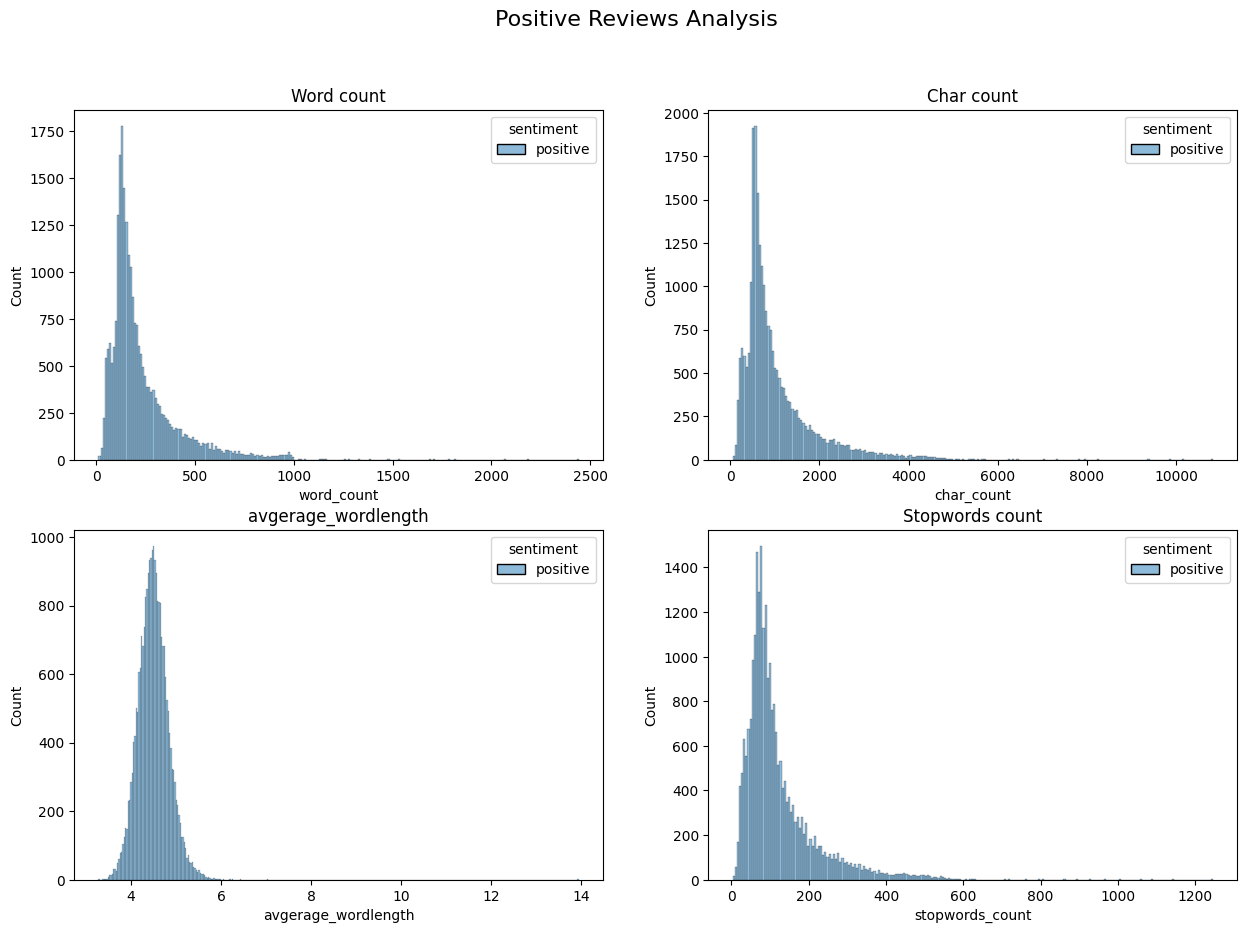

In [9]:
def histplot_analysis(data,columns,hue,name):
  """
    Function to generate a grid of histogram plots for analyzing labels.
  """
  plt.figure(figsize=(15,10))
  plt.subplot(2,2,1)

  sns.histplot(data=data, x=columns[0], hue='sentiment')
  plt.title('Word count')

  plt.subplot(2,2,2)
  sns.histplot(data=data, x=columns[1], hue='sentiment')
  plt.title('Char count')

  plt.subplot(2,2,3)
  sns.histplot(data=data, x=columns[2], hue='sentiment')
  plt.title('avgerage_wordlength')

  plt.subplot(2,2,4)
  sns.histplot(data=data, x=columns[3], hue='sentiment')
  plt.title('Stopwords count')

  plt.suptitle(f'{name}', fontsize=16)
  plt.show()

# Histogram analysis for positive Reviews
histplot_analysis(positive_reviews,positive_reviews.columns[2:6],hue="sentiment",name="Positive Reviews Analysis")

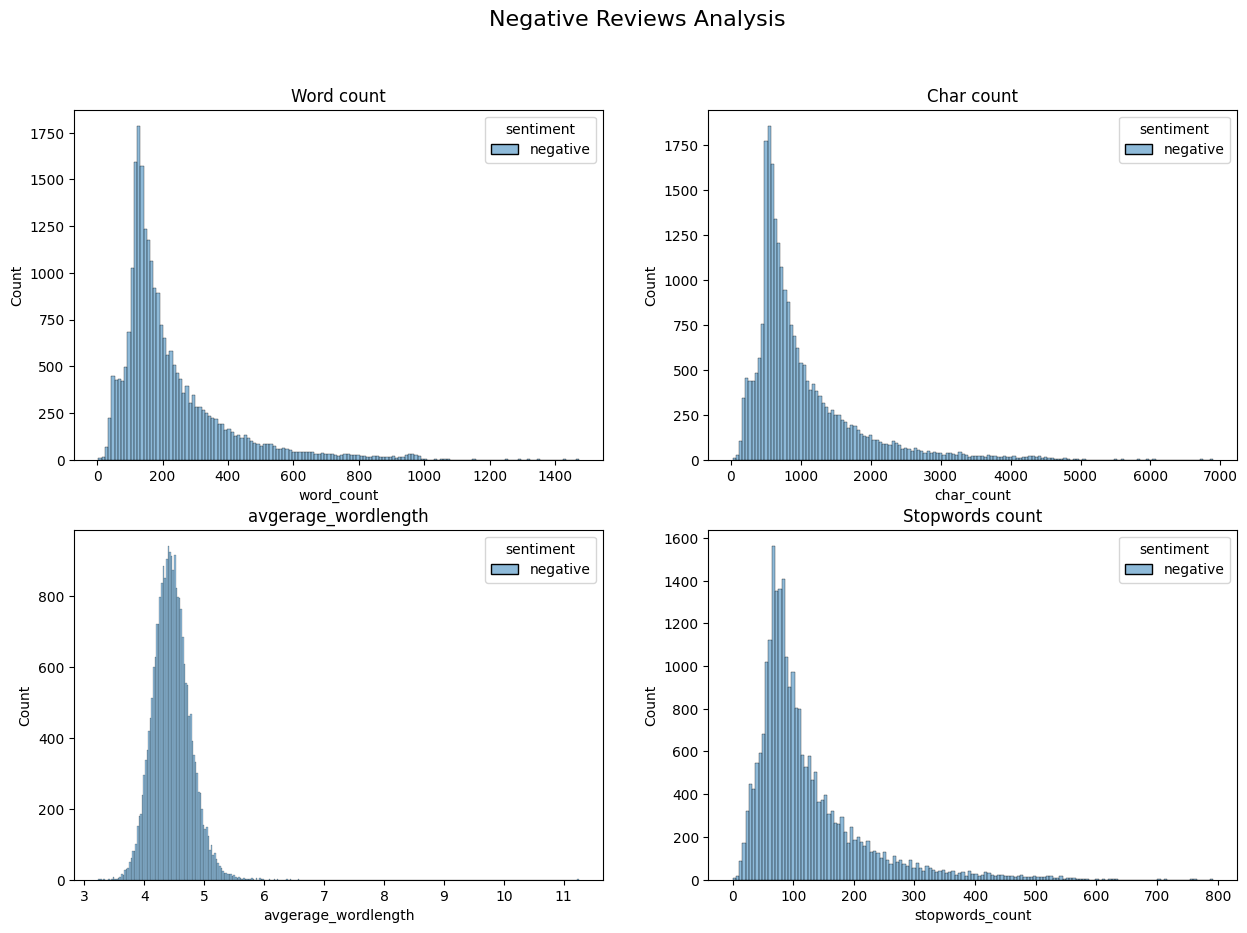

In [10]:
# Histogram analysis for negative Reviews
histplot_analysis(negative_reviews,negative_reviews.columns[2:6],hue="sentiment",name="Negative Reviews Analysis")

In [11]:
df=data_IMDB.copy()
df.head()

review sentiment  word_count  \
0  one of the other reviewers has mentioned that ...  positive         300   
1  a wonderful little production the filming tech...  positive         156   
2  i thought this was a wonderful way to spend ti...  positive         161   
3  basically theres a family where a little boy j...  negative         128   
4  petter matteis love in the time of money is a ...  positive         222   

   char_count  avgerage_wordlength  stopwords_count  \
0        1364             4.546667              154   
1         781             5.006410               82   
2         712             4.422360               88   
3         554             4.328125               68   
4        1016             4.576577              112   

                            review_without_stopwords  \
0  reviewers mentioned watching oz episode youll ...   
1  wonderful little production filming technique ...   
2  thought wonderful way spend time hot summer we...   
3  basically theres family little boy jake thinks...   
4  petter matteis love time money visually stunni...   

   word_count_without_stopwords  char_count_without_stopwords  \
0                           146                           909   
1                            74                           525   
2                            73                           462   
3                            60                           365   
4                           110                           685   

   average_wordlength_without_stopwords  stopwords_counts_without_stopwords  
0                              6.226027                                   0  
1                              7.094595                                   0  
2                              6.328767                                   0  
3                              6.083333                                   0  
4                              6.227273                                   0

In [12]:
def Evaluation_metrics(y_pred, y_test,ML:bool):
  """
    Function to calculate evaluation metrics (Accuracy, Precision, Recall, F1 score)
    ML (bool): Indicates whether the evaluation is for machine learning algorithm or Deep learning algorithm (True) or not (False).
  """

  if ML:
    return print("Accuracy:", accuracy_score(y_test, y_pred), "Precision:", precision_score(y_test, y_pred,pos_label="positive"),
                 "Recall:", recall_score(y_test, y_pred,pos_label="positive"), "F1 score:", f1_score(y_test, y_pred,pos_label="positive"))
  else:
    # If the probability is higher than 50% its True (1) less False(0)
    y_pred = (y_pred > 0.5).astype(int)
    return print("Accuracy:", accuracy_score(y_test, y_pred), "Precision:", precision_score(y_test, y_pred),
                 "Recall:", recall_score(y_test, y_pred), "F1 score:", f1_score(y_test, y_pred))

# **Support Vector Machine & Logistic Regression with Stemming**

In [13]:
# Initialize the Porter Stemmer
porter_stemmer = PorterStemmer()

def tokenize_and_stem(text):
    """
     Function to tokenize and stem
    """
    # Tokenizing text
    tokens = nltk.word_tokenize(text)
    # Stem each Token
    stems = [porter_stemmer.stem(token) for token in tokens]
    return stems

# Splitting The Data
X_train, X_test, y_train, y_test = train_test_split(df["review_without_stopwords"], df['sentiment'],test_size=0.2,random_state=0,stratify=df['sentiment'])

# Create a TF-IDF vectorizer to convert text to a vector
tf_idf_vectorizer = TfidfVectorizer(tokenizer=tokenize_and_stem)

# Transform training/testing text into TF-IDF vectors
X_train_tf_idf = tf_idf_vectorizer.fit_transform(X_train)
X_test_tf_idf = tf_idf_vectorizer.transform(X_test)

# Initialize Linear SVM
SVC = LinearSVC()

# Training The model
SVC.fit(X_train_tf_idf, y_train)

# Evaluating The model
Evaluation_metrics(SVC.predict(X_test_tf_idf),y_test,True)

Accuracy: 0.887 Precision: 0.8757281553398059 Recall: 0.902 F1 score: 0.8886699507389163


In [14]:
# Initialize logistic Regression model
Logistic_model = LogisticRegression(max_iter=1000)

# Training The model
Logistic_model.fit(X_train_tf_idf, y_train)

# Predictions on the test set
y_pred = Logistic_model.predict(X_test_tf_idf)

# Evaluating The model
Evaluation_metrics(Logistic_model.predict(X_test_tf_idf),y_test,True)

Accuracy: 0.8871 Precision: 0.8728568676555577 Recall: 0.9062 F1 score: 0.8892159748797959


# **Support Vector Machine & Logistic Regression without Stemming**

In [15]:
def tokenize(text):
  #Toknize the text
    return nltk.word_tokenize(text)

# Create a TF-IDF vectorizer to convert text to a vector
tf_idf_vectorizer = TfidfVectorizer(tokenizer=tokenize)

# Transform training/testing text into TF-IDF vectors
X_train_tf_idf = tf_idf_vectorizer.fit_transform(X_train)
X_test_tf_idf = tf_idf_vectorizer.transform(X_test)

# Initialize Linear SVM
SVC = LinearSVC()

# Training The model
SVC.fit(X_train_tf_idf, y_train)

# Evaluating The model
Evaluation_metrics(SVC.predict(X_test_tf_idf),y_test,True)


Accuracy: 0.8939 Precision: 0.8864037669217186 Recall: 0.9036 F1 score: 0.8949192829553332


In [16]:
# Initialize logistic Regression model
Logistic_model = LogisticRegression(max_iter=1000)

# Train the logistic regression model
Logistic_model.fit(X_train_tf_idf, y_train)

# Predictions on the test set
y_pred = Logistic_model.predict(X_test_tf_idf)
# Evaluating The model
Evaluation_metrics(Logistic_model.predict(X_test_tf_idf),y_test,True)

Accuracy: 0.892 Precision: 0.8817686014803272 Recall: 0.9054 F1 score: 0.8934280639431617


# **Word2Vec**

In [17]:
import gensim.downloader as api
# Loading the pre-trained model from the Google News corpus
w2v = api.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [18]:
def word_to_vector(word):
    """
  function to convert each word to vector representation
    """
    try:
        return w2v[word]
    except KeyError:
        return None

def vectorization(df):
  """
  Function to perform vectorization for the data
  """
  for i in range(2):
    if i == 0 :
      df['new_review'] = df['review_without_stopwords'].apply(tokenize_and_stem)
      temp = "review_vec_stemmed"

    else:
      df['new_review']=list(df['review_without_stopwords'].str.split())
      temp = "review_vec"

    df['word_vectors'] = df['new_review'].apply(lambda x: [word_to_vector(word) for word in x])
    df['review_vector'] = df['word_vectors'].apply(lambda x: [v for v in x if v is not None])
    df[temp] = df['review_vector'].apply(lambda x: np.mean(x, axis=0) if len(x) > 0 else np.zeros(w2v.vector_size))
    # Dropping intermediate columns
    df.drop("new_review",axis=1,inplace=True)
    df.drop("word_vectors",axis=1,inplace=True)
    df.drop("review_vector",axis=1,inplace=True)

In [19]:
vectorization(df)

# **Deep Learning Model ( Without Stemming)**


# **Neural Network**

In [20]:
def plot_model(history):
  """
   Function to plot the training and validation loss
  """
  # Getting the loss and accuracy for both training and validation
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']
  epochs = range(1, len(loss) + 1)

  # Plot training and validation loss
  plt.subplot(2,1,1)
  plt.plot(epochs, loss, 'b-', label='Training loss')
  plt.plot(epochs, val_loss, 'r-', label='Validation loss')
  plt.title('Training and validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  # plot training and validation accuracy
  plt.subplot(2,1,2)
  plt.plot(epochs, accuracy, 'b-', label='Training accuracy')
  plt.plot(epochs, val_accuracy, 'r-', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()

  plt.tight_layout()
  plt.show()


In [21]:
# Split the Feature and Target
X = df['review_vec']
y = df['sentiment']
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0,stratify=y)

# Encoding the labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [22]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , Dropout

# convert features to numpy array
X_train = np.array([np.array(x) for x in X_train])
X_test = np.array([np.array(x) for x in X_test])
X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)

# Build The model
model = Sequential()
model.add(Dense(16, activation="relu", input_shape=(X_train.shape[1],)))
model.add(Dense(8, activation="relu"))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train The model
History_1=model.fit(X_train, y_train_encoded, epochs=10, batch_size=32,validation_split=0.2)

Epoch 1/10
1000/1000 [==============================] - 6s 3ms/step - loss: 0.4420 - accuracy: 0.8049 - val_loss: 0.3891 - val_accuracy: 0.8269
Epoch 2/10
1000/1000 [==============================] - 3s 3ms/step - loss: 0.3603 - accuracy: 0.8451 - val_loss: 0.3632 - val_accuracy: 0.8409
Epoch 3/10
1000/1000 [==============================] - 3s 3ms/step - loss: 0.3522 - accuracy: 0.8468 - val_loss: 0.3604 - val_accuracy: 0.8421
Epoch 4/10
1000/1000 [==============================] - 3s 3ms/step - loss: 0.3485 - accuracy: 0.8499 - val_loss: 0.3572 - val_accuracy: 0.8445
Epoch 5/10
1000/1000 [==============================] - 3s 3ms/step - loss: 0.3449 - accuracy: 0.8519 - val_loss: 0.3555 - val_accuracy: 0.8449
Epoch 6/10
1000/1000 [==============================] - 3s 3ms/step - loss: 0.3422 - accuracy: 0.8535 - val_loss: 0.3649 - val_accuracy: 0.8386
Epoch 7/10
1000/1000 [==============================] - 3s 3ms/step - loss: 0.3414 - accuracy: 0.8540 - val_loss: 0.3533 - val_accuracy:

In [23]:
Evaluation_metrics(model.predict(X_test),y_test_encoded,False)

313/313 [==============================] - 1s 2ms/step
Accuracy: 0.8525 Precision: 0.8648312978679362 Recall: 0.8356 F1 score: 0.8499643983318076


In [24]:
plot_model(History_1)

# **LSTM**

In [25]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
# Padding sequences to guarantee consistent length
X_train_padded = pad_sequences(X_train, maxlen=300, dtype='float32', padding='post')
X_test_padded = pad_sequences(X_test, maxlen=300, dtype='float32', padding='post')
# Convert it to a shape compatible with LSTM
X_train_padded=tf.reshape(X_train, (40000, 1, 300))
X_test_padded = tf.reshape(X_test, (10000, 1, 300))

In [26]:
from tensorflow.keras.layers import LSTM, Dense,Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Build The model
model = Sequential()
model.add(LSTM(units=64, input_shape=(X_train_padded.shape[1], X_train_padded.shape[2]),return_sequences=True, activation='tanh'))
model.add(LSTM(units=32, activation='tanh'))
model.add(Dense(units=16, activation='relu'))
#model.add(Dropout(0.3))
model.add(Dense(units=1,activation="sigmoid"))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train The model
History_2=model.fit(X_train_padded, y_train_encoded, epochs=10, batch_size=32,validation_split=0.2)

Epoch 1/10
1000/1000 [==============================] - 10s 6ms/step - loss: 0.4094 - accuracy: 0.8143 - val_loss: 0.3980 - val_accuracy: 0.8206
Epoch 2/10
1000/1000 [==============================] - 5s 5ms/step - loss: 0.3576 - accuracy: 0.8448 - val_loss: 0.3688 - val_accuracy: 0.8374
Epoch 3/10
1000/1000 [==============================] - 5s 5ms/step - loss: 0.3520 - accuracy: 0.8481 - val_loss: 0.3586 - val_accuracy: 0.8421
Epoch 4/10
1000/1000 [==============================] - 5s 5ms/step - loss: 0.3477 - accuracy: 0.8487 - val_loss: 0.3632 - val_accuracy: 0.8397
Epoch 5/10
1000/1000 [==============================] - 5s 5ms/step - loss: 0.3438 - accuracy: 0.8514 - val_loss: 0.4320 - val_accuracy: 0.8090
Epoch 6/10
1000/1000 [==============================] - 5s 5ms/step - loss: 0.3406 - accuracy: 0.8531 - val_loss: 0.3558 - val_accuracy: 0.8436
Epoch 7/10
1000/1000 [==============================] - 5s 5ms/step - loss: 0.3407 - accuracy: 0.8509 - val_loss: 0.3520 - val_accuracy

In [27]:
Evaluation_metrics(model.predict(X_test_padded),y_test_encoded,False)

313/313 [==============================] - 1s 2ms/step
Accuracy: 0.8547 Precision: 0.8391661885637789 Recall: 0.8776 F1 score: 0.8579528790693126


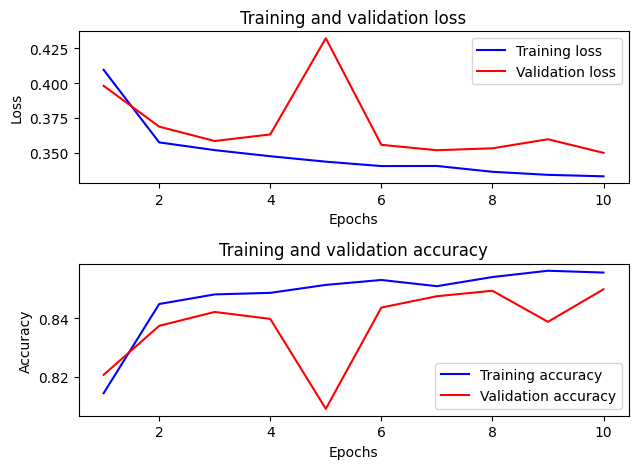

In [28]:
plot_model(History_2)

# **CNN**

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

# Build The model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(1, 300), padding='same'))
model.add(MaxPooling1D(pool_size=2,padding='same'))
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size=2,padding='same'))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile The model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
History_3=model.fit(X_train_padded, y_train_encoded, epochs=10, batch_size=32, validation_split=0.2)

#Evaluate The model
Evaluation_metrics(model.predict(X_test_padded),y_test_encoded,False)


Epoch 1/10
1000/1000 [==============================] - 7s 4ms/step - loss: 0.4034 - accuracy: 0.8208 - val_loss: 0.3677 - val_accuracy: 0.8376
Epoch 2/10
1000/1000 [==============================] - 4s 4ms/step - loss: 0.3550 - accuracy: 0.8458 - val_loss: 0.3604 - val_accuracy: 0.8422
Epoch 3/10
1000/1000 [==============================] - 4s 4ms/step - loss: 0.3467 - accuracy: 0.8503 - val_loss: 0.3755 - val_accuracy: 0.8339
Epoch 4/10
1000/1000 [==============================] - 4s 4ms/step - loss: 0.3440 - accuracy: 0.8492 - val_loss: 0.3547 - val_accuracy: 0.8447
Epoch 5/10
1000/1000 [==============================] - 4s 4ms/step - loss: 0.3362 - accuracy: 0.8543 - val_loss: 0.3511 - val_accuracy: 0.8482
Epoch 6/10
1000/1000 [==============================] - 4s 4ms/step - loss: 0.3335 - accuracy: 0.8554 - val_loss: 0.3517 - val_accuracy: 0.8505
Epoch 7/10
1000/1000 [==============================] - 4s 4ms/step - loss: 0.3298 - accuracy: 0.8579 - val_loss: 0.3453 - val_accuracy:

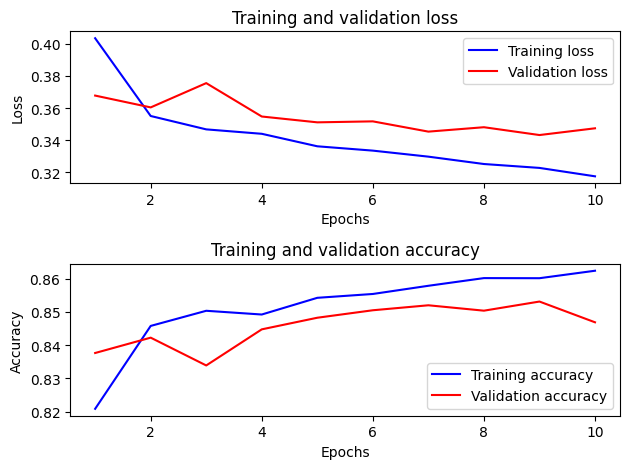

In [30]:
plot_model(History_3)

# **CNN LSTM**

In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Flatten

#Build The Model
model = Sequential()

# Convolutional layers
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train_padded.shape[1], X_train_padded.shape[2]),padding='same'))
model.add(MaxPooling1D(pool_size=2,padding='same'))

# LSTM layer
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(32))

# Dense layers
model.add(Dense(100, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
History_4=model.fit(X_train_padded, y_train_encoded, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate The model
Evaluation_metrics(model.predict(X_test_padded),y_test_encoded,False)


Epoch 1/10
1000/1000 [==============================] - 10s 6ms/step - loss: 0.4016 - accuracy: 0.8149 - val_loss: 0.3740 - val_accuracy: 0.8294
Epoch 2/10
1000/1000 [==============================] - 6s 6ms/step - loss: 0.3591 - accuracy: 0.8433 - val_loss: 0.3588 - val_accuracy: 0.8435
Epoch 3/10
1000/1000 [==============================] - 6s 6ms/step - loss: 0.3507 - accuracy: 0.8477 - val_loss: 0.3922 - val_accuracy: 0.8259
Epoch 4/10
1000/1000 [==============================] - 6s 6ms/step - loss: 0.3446 - accuracy: 0.8493 - val_loss: 0.3596 - val_accuracy: 0.8445
Epoch 5/10
1000/1000 [==============================] - 5s 5ms/step - loss: 0.3386 - accuracy: 0.8541 - val_loss: 0.3501 - val_accuracy: 0.8484
Epoch 6/10
1000/1000 [==============================] - 6s 6ms/step - loss: 0.3363 - accuracy: 0.8544 - val_loss: 0.3502 - val_accuracy: 0.8490
Epoch 7/10
1000/1000 [==============================] - 5s 5ms/step - loss: 0.3324 - accuracy: 0.8561 - val_loss: 0.3463 - val_accuracy

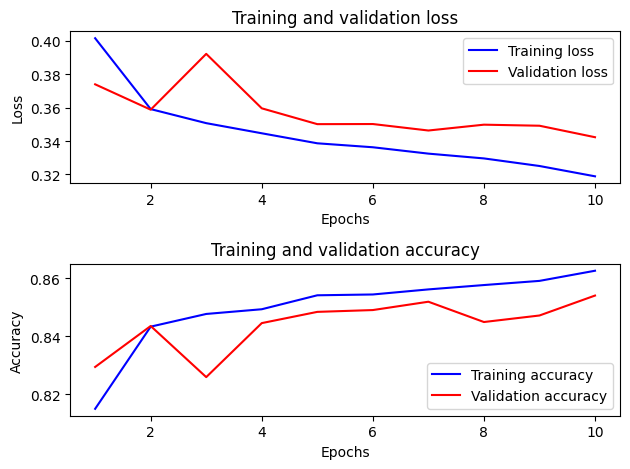

In [32]:
plot_model(History_4)

# **Deep Learning Model ( With Stemming)**


# **Neural Network**

In [33]:
# Split the Feature and Target
X = df['review_vec_stemmed']
y = df['sentiment']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0,stratify=y)

# Encoding The Labels
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# convert features to numpy array
X_train = np.array([np.array(x) for x in X_train])
X_test = np.array([np.array(x) for x in X_test])
X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)

# Build The model
model = Sequential()
model.add(Dense(16, activation="relu", input_shape=(X_train.shape[1],)))
model.add(Dense(8, activation="relu"))
model.add(Dense(1, activation='sigmoid'))

# Compile The model model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train The model
History_5=model.fit(X_train, y_train_encoded, epochs=10, batch_size=32,validation_split=0.2)

Epoch 1/10
1000/1000 [==============================] - 4s 3ms/step - loss: 0.5235 - accuracy: 0.7487 - val_loss: 0.4677 - val_accuracy: 0.7799
Epoch 2/10
1000/1000 [==============================] - 3s 3ms/step - loss: 0.4393 - accuracy: 0.7990 - val_loss: 0.4441 - val_accuracy: 0.7989
Epoch 3/10
1000/1000 [==============================] - 3s 3ms/step - loss: 0.4298 - accuracy: 0.8054 - val_loss: 0.4363 - val_accuracy: 0.8033
Epoch 4/10
1000/1000 [==============================] - 3s 3ms/step - loss: 0.4239 - accuracy: 0.8071 - val_loss: 0.4329 - val_accuracy: 0.8027
Epoch 5/10
1000/1000 [==============================] - 3s 3ms/step - loss: 0.4205 - accuracy: 0.8101 - val_loss: 0.4312 - val_accuracy: 0.8056
Epoch 6/10
1000/1000 [==============================] - 3s 3ms/step - loss: 0.4195 - accuracy: 0.8104 - val_loss: 0.4305 - val_accuracy: 0.8054
Epoch 7/10
1000/1000 [==============================] - 3s 3ms/step - loss: 0.4150 - accuracy: 0.8115 - val_loss: 0.4425 - val_accuracy:

In [34]:
# Evaluate The model
Evaluation_metrics(model.predict(X_test),y_test_encoded,False)

313/313 [==============================] - 1s 1ms/step
Accuracy: 0.8147 Precision: 0.793618212353051 Recall: 0.8506 F1 score: 0.8211217298967081


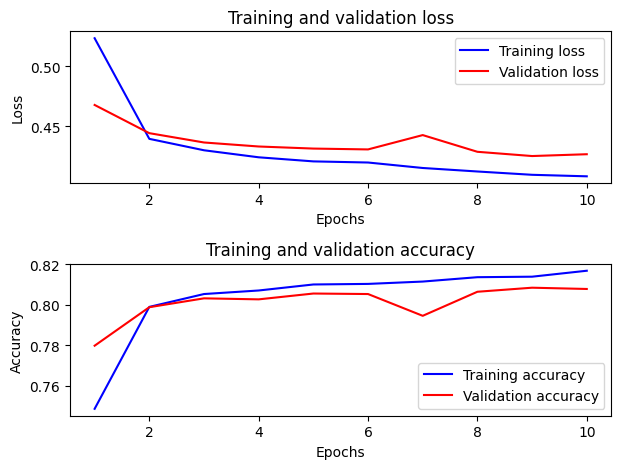

In [35]:
plot_model(History_5)

# **LSTM**

In [36]:
# Padding sequences to guarantee consistent length
X_train_padded = pad_sequences(X_train, maxlen=300, dtype='float32', padding='post')
X_test_padded = pad_sequences(X_test, maxlen=300, dtype='float32', padding='post')
# Convert it to a shape compatible with LSTM
X_train_padded=tf.reshape(X_train, (40000, 1, 300))
X_test_padded = tf.reshape(X_test, (10000, 1, 300))

# Build The model
model = Sequential()
model.add(LSTM(units=64, input_shape=(X_train_padded.shape[1], X_train_padded.shape[2]),return_sequences=True, activation='tanh'))
model.add(LSTM(units=32, activation='tanh'))
model.add(Dense(units=16, activation='relu'))
#model.add(Dropout(0.3))
model.add(Dense(units=1,activation="sigmoid"))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train The Model
History_6=model.fit(X_train_padded, y_train_encoded, epochs=10, batch_size=32,validation_split=0.2)

Epoch 1/10
1000/1000 [==============================] - 9s 6ms/step - loss: 0.4899 - accuracy: 0.7553 - val_loss: 0.4490 - val_accuracy: 0.7949
Epoch 2/10
1000/1000 [==============================] - 5s 5ms/step - loss: 0.4330 - accuracy: 0.8025 - val_loss: 0.4552 - val_accuracy: 0.7859
Epoch 3/10
1000/1000 [==============================] - 5s 5ms/step - loss: 0.4265 - accuracy: 0.8074 - val_loss: 0.4440 - val_accuracy: 0.7941
Epoch 4/10
1000/1000 [==============================] - 5s 5ms/step - loss: 0.4226 - accuracy: 0.8085 - val_loss: 0.4319 - val_accuracy: 0.8035
Epoch 5/10
1000/1000 [==============================] - 5s 5ms/step - loss: 0.4191 - accuracy: 0.8096 - val_loss: 0.4328 - val_accuracy: 0.8034
Epoch 6/10
1000/1000 [==============================] - 5s 5ms/step - loss: 0.4159 - accuracy: 0.8119 - val_loss: 0.4460 - val_accuracy: 0.7952
Epoch 7/10
1000/1000 [==============================] - 5s 5ms/step - loss: 0.4132 - accuracy: 0.8119 - val_loss: 0.4496 - val_accuracy:

In [37]:
# Evaluate The model
Evaluation_metrics(model.predict(X_test_padded),y_test_encoded,False)

313/313 [==============================] - 1s 2ms/step
Accuracy: 0.8136 Precision: 0.7955145118733509 Recall: 0.8442 F1 score: 0.8191344847661556


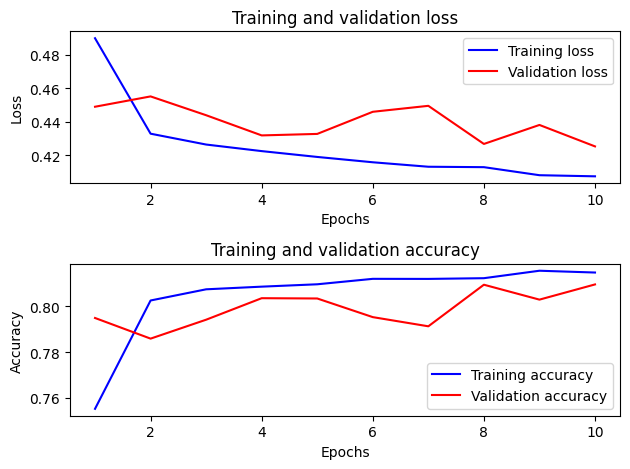

In [38]:
plot_model(History_6)

# **CNN**

In [39]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

#Build The Model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(1, 300), padding='same'))
model.add(MaxPooling1D(pool_size=2,padding='same'))
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size=2,padding='same'))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile The model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
History_7=model.fit(X_train_padded, y_train_encoded, epochs=10, batch_size=32, validation_split=0.2)
#Evaluate The modell
Evaluation_metrics(model.predict(X_test_padded),y_test_encoded,False)


Epoch 1/10
1000/1000 [==============================] - 5s 4ms/step - loss: 0.4780 - accuracy: 0.7744 - val_loss: 0.4387 - val_accuracy: 0.8004
Epoch 2/10
1000/1000 [==============================] - 4s 4ms/step - loss: 0.4338 - accuracy: 0.8009 - val_loss: 0.4432 - val_accuracy: 0.7959
Epoch 3/10
1000/1000 [==============================] - 4s 4ms/step - loss: 0.4233 - accuracy: 0.8075 - val_loss: 0.4277 - val_accuracy: 0.8048
Epoch 4/10
1000/1000 [==============================] - 4s 4ms/step - loss: 0.4199 - accuracy: 0.8089 - val_loss: 0.4458 - val_accuracy: 0.7937
Epoch 5/10
1000/1000 [==============================] - 4s 4ms/step - loss: 0.4134 - accuracy: 0.8132 - val_loss: 0.4456 - val_accuracy: 0.7960
Epoch 6/10
1000/1000 [==============================] - 4s 4ms/step - loss: 0.4083 - accuracy: 0.8135 - val_loss: 0.4267 - val_accuracy: 0.8075
Epoch 7/10
1000/1000 [==============================] - 4s 4ms/step - loss: 0.4019 - accuracy: 0.8172 - val_loss: 0.4461 - val_accuracy:

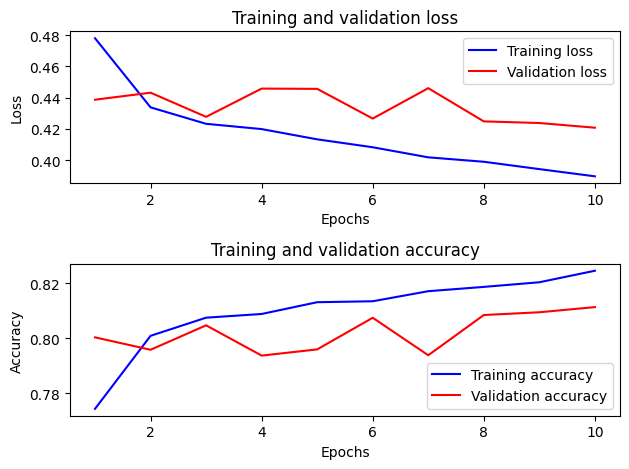

In [40]:
plot_model(History_7)

# **CNN LSTM**

In [41]:
# Build The Model
model = Sequential()

# Convolutional layers
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train_padded.shape[1], X_train_padded.shape[2]),padding='same'))
model.add(MaxPooling1D(pool_size=2,padding='same'))

# LSTM layer
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(32))

# Dense layers
model.add(Dense(100, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
History_8=model.fit(X_train_padded, y_train_encoded, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate The model
Evaluation_metrics(model.predict(X_test_padded),y_test_encoded,False)
plot_model(History_8)

Epoch 1/10
1000/1000 [==============================] - 11s 6ms/step - loss: 0.4846 - accuracy: 0.7628 - val_loss: 0.4439 - val_accuracy: 0.7968
Epoch 2/10
1000/1000 [==============================] - 6s 6ms/step - loss: 0.4360 - accuracy: 0.8002 - val_loss: 0.4493 - val_accuracy: 0.7928
Epoch 3/10
1000/1000 [==============================] - 6s 6ms/step - loss: 0.4247 - accuracy: 0.8067 - val_loss: 0.4309 - val_accuracy: 0.8021
Epoch 4/10
1000/1000 [==============================] - 6s 6ms/step - loss: 0.4182 - accuracy: 0.8099 - val_loss: 0.4272 - val_accuracy: 0.8067
Epoch 5/10
1000/1000 [==============================] - 5s 5ms/step - loss: 0.4130 - accuracy: 0.8134 - val_loss: 0.4387 - val_accuracy: 0.8014
Epoch 6/10
1000/1000 [==============================] - 6s 6ms/step - loss: 0.4079 - accuracy: 0.8166 - val_loss: 0.4211 - val_accuracy: 0.8134
Epoch 7/10
1000/1000 [==============================] - 6s 6ms/step - loss: 0.4023 - accuracy: 0.8167 - val_loss: 0.4548 - val_accuracy